In [2]:
import os
import cv2
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold


In [3]:
sns.set_theme(style="darkgrid", palette="pastel")
color = sns.color_palette(palette = "pastel")

# **Read and exploratory data analysis**

In [4]:
classes = ['Lung Adenocarcinoma', 'Lung Benign Tissue', 'Lung Squamous Cell Carcinoma']

In [5]:
data_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set"

filepaths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds:
    if fold == "colon_image_sets":
        continue
    else:
        foldpath = os.path.join(data_dir, fold)
        flist = os.listdir(foldpath)

        for f in flist:
            f_path = os.path.join(foldpath, f)
            filelist = os.listdir(f_path)

            for file in filelist:
                fpath = os.path.join(f_path, file)
                filepaths.append(fpath)

                if f == "lung_n":
                    labels.append("Lung Benign Tissue")
                elif f == "lung_aca":
                    labels.append("Lung Adenocarcinoma")
                elif f == "lung_scc":
                    labels.append("Lung Squamous Cell Carcinoma")
                    
fpaths = pd.Series(filepaths, name="filepaths")
labels_ = pd.Series(labels, name="labels")

df = pd.concat([fpaths, labels_], axis = 1)


In [6]:
print(df["labels"].value_counts())

labels
Lung Adenocarcinoma             5000
Lung Squamous Cell Carcinoma    5000
Lung Benign Tissue              5000
Name: count, dtype: int64


In [7]:
strat = df["labels"]

train_df , test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state=42, stratify= strat)



In [8]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/255.0  # scale pixel between 0 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

test batch size:  75   test steps:  40
Found 12000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [9]:
def display_images(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<9:
        r=length
    else:
        r=9
    for i in range(r):
        plt.subplot(3, 3, i + 1)
        image=(images[i]+1 )/2 
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

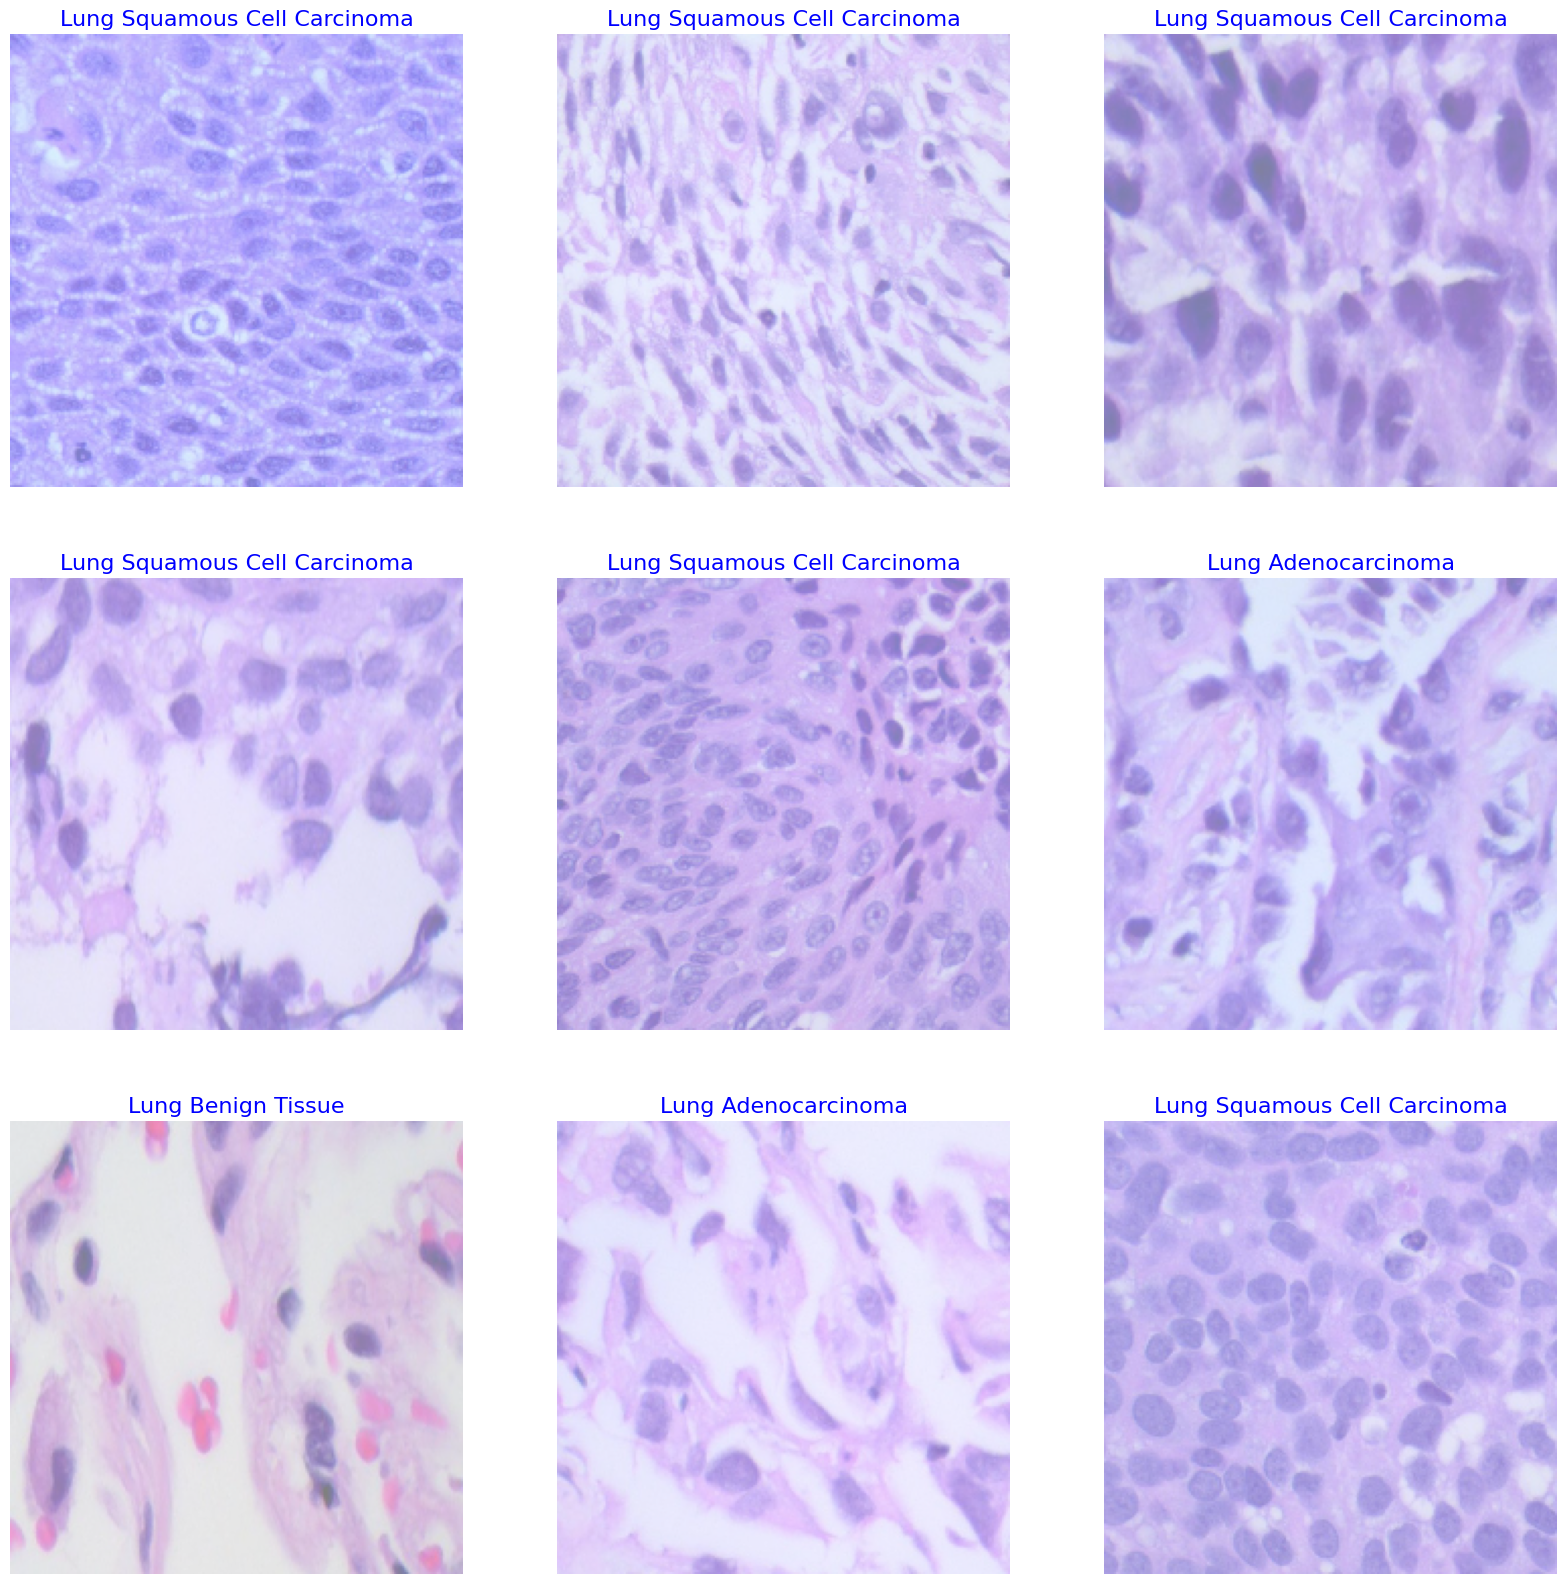

In [10]:
display_images((train_gen))

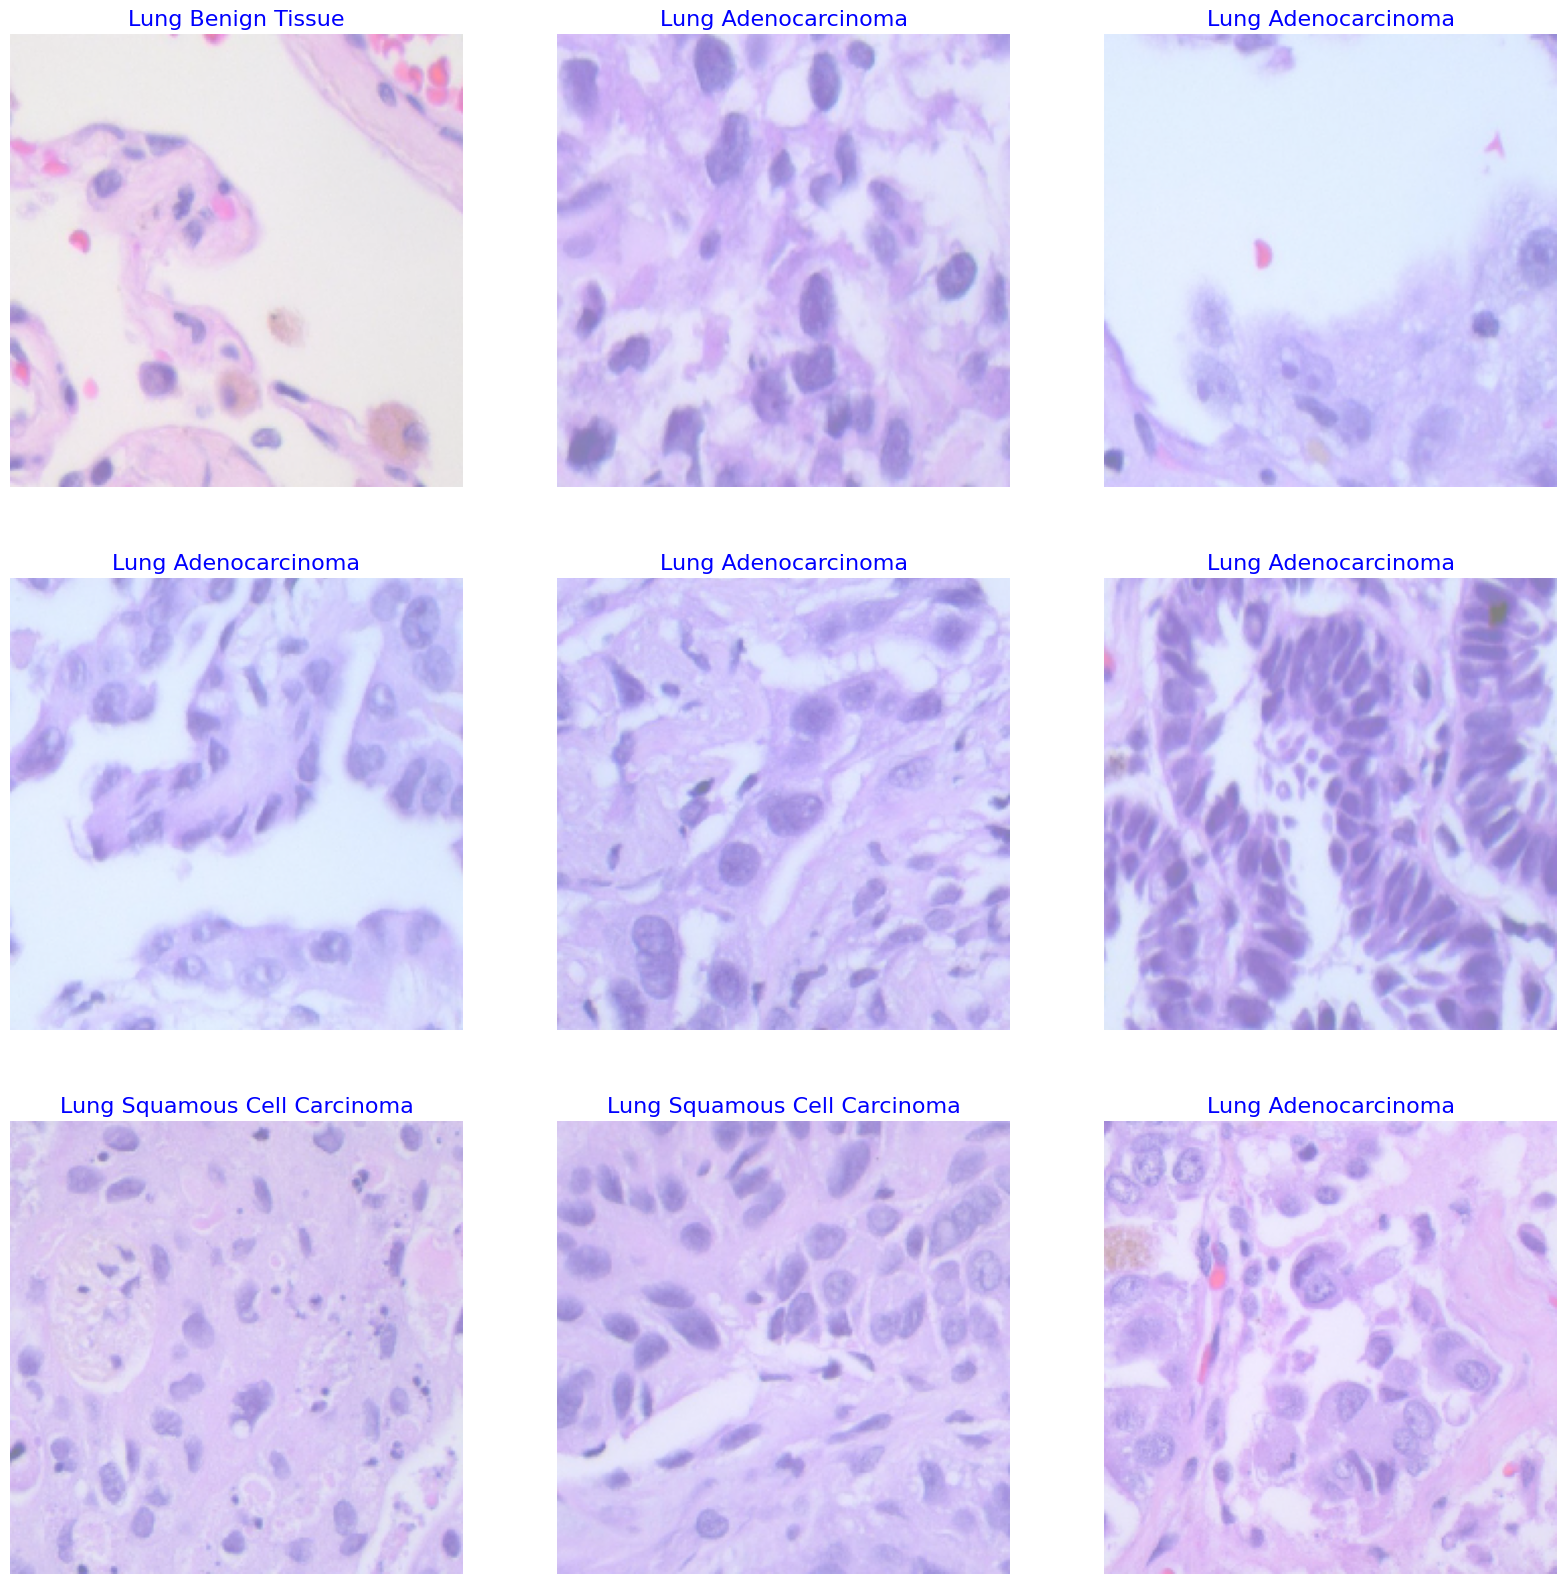

In [11]:
display_images((test_gen))

In [12]:
test_df

filepaths  \
11735  /kaggle/input/lung-and-colon-cancer-histopatho...   
4341   /kaggle/input/lung-and-colon-cancer-histopatho...   
1852   /kaggle/input/lung-and-colon-cancer-histopatho...   
3072   /kaggle/input/lung-and-colon-cancer-histopatho...   
2237   /kaggle/input/lung-and-colon-cancer-histopatho...   
...                                                  ...   
5166   /kaggle/input/lung-and-colon-cancer-histopatho...   
7094   /kaggle/input/lung-and-colon-cancer-histopatho...   
9950   /kaggle/input/lung-and-colon-cancer-histopatho...   
13862  /kaggle/input/lung-and-colon-cancer-histopatho...   
2690   /kaggle/input/lung-and-colon-cancer-histopatho...   

                             labels  
11735            Lung Benign Tissue  
4341            Lung Adenocarcinoma  
1852            Lung Adenocarcinoma  
3072            Lung Adenocarcinoma  
2237            Lung Adenocarcinoma  
...                             ...  
5166   Lung Squamous Cell Carcinoma  
7094   Lung Squamous Cell Carcinoma  
9950   Lung Squamous Cell Carcinoma  
13862            Lung Benign Tissue  
2690            Lung Adenocarcinoma  

[3000 rows x 2 columns]

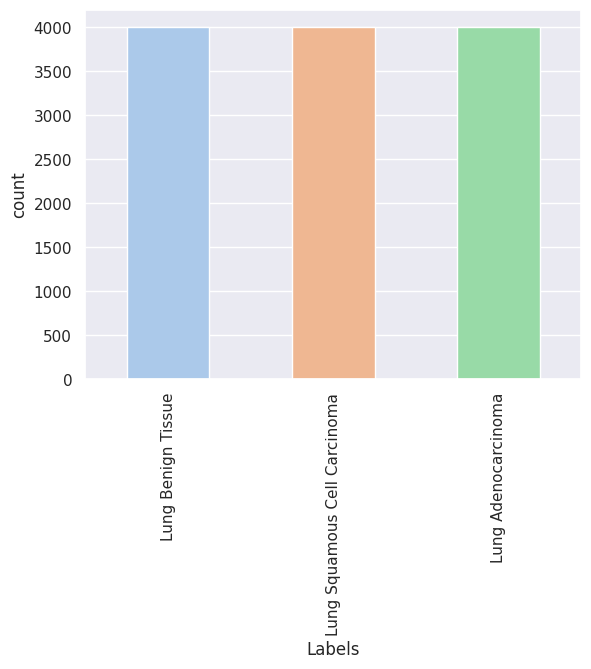

In [13]:
# Vẽ biểu đồ
ax = sns.countplot(train_df, x='labels', width=0.5)

# Đặt tiêu đề cho trục x
ax.set_xlabel('Labels')

# Quay nhãn trên trục x ngược lại (180 độ)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Hiển thị biểu đồ
plt.show()

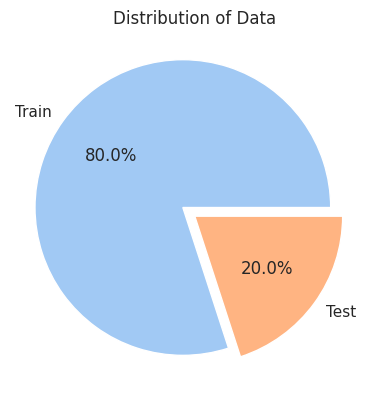

In [14]:
# Histogram of the percentage of labels in the data set

def display_pie_chart(train, test):
    total_size = 15000
    percentages = [len(train) / total_size * 100,
                   len(test) / total_size * 100]
    labels = ['Train', 'Test']

    plt.pie(percentages, labels=labels, autopct="%1.1f%%", explode=[0.1, 0])
    plt.title('Distribution of Data')
    plt.show()
    
display_pie_chart(train_df, test_df)
    

# **GLCM**

In [15]:
def compute_glcm_features(image):
    distances = [1]  # You can experiment with different distances
    #angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # You can experiment with different angles
    glcm = graycomatrix(image, distances=distances, angles=[0], levels=256,
                        symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    entropy = -np.sum(glcm * np.log(glcm + 1e-10))  # Compute entropy manually
    return np.concatenate((contrast, energy, homogeneity, correlation, [entropy]))

In [16]:
def load_and_compute_glcm_features(paths):
    features = []
    for path in paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        glcm_features = compute_glcm_features(image)
        features.append(glcm_features)
    return np.array(features)

In [17]:
X_features = load_and_compute_glcm_features(train_df['filepaths'])

In [18]:
X_features.shape

(12000, 5)

In [19]:
X_features[0]

array([15.24709196,  0.04993958,  0.4484553 ,  0.99563558,  7.19145369])

In [20]:
columns = []
 # Each GLCM feature set consists of 5 features (contrast, energy, homogeneity, correlation, entropy)
columns.extend(["Contrast", "Energy", "Homogeneity", "Correlation", "Entropy"])

df_train = pd.DataFrame(X_features, columns=columns)

In [21]:
df_train

Contrast    Energy  Homogeneity  Correlation   Entropy
0      15.247092  0.049940     0.448455     0.995636  7.191454
1       7.811994  0.049183     0.420259     0.991010  6.645922
2      10.780773  0.066392     0.516103     0.996156  6.737162
3      20.330544  0.061243     0.451985     0.993823  7.048412
4      19.789626  0.044366     0.385595     0.990726  7.154070
...          ...       ...          ...          ...       ...
11995   9.899072  0.100422     0.584643     0.995865  6.048204
11996   7.465351  0.038784     0.434301     0.996630  7.094896
11997  14.956478  0.027917     0.345535     0.994349  7.614012
11998  16.930417  0.030430     0.324775     0.991723  7.511381
11999  17.675807  0.061443     0.464150     0.994368  6.976058

[12000 rows x 5 columns]

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df['labels'])

In [23]:
print("Classes:", label_encoder.classes_)

Classes: ['Lung Adenocarcinoma' 'Lung Benign Tissue' 'Lung Squamous Cell Carcinoma']


# **Confusion Matrix**

In [24]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()


# **Test data**

In [25]:
X_test_features = load_and_compute_glcm_features(test_df['filepaths'])

In [26]:
test_labels_encoded=label_encoder.transform(test_df['labels'])

# **SVM**

In [27]:
from sklearn.svm import SVC

# Đặt phương pháp khởi tạo
with joblib.parallel_backend('threading', n_jobs=-1):
    # Tạo pipeline với scaler và SVC
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('classifier', SVC())  # Support Vector Classifier
    ])

    # Định nghĩa các siêu tham số để tìm kiếm
    param_grid_svm = {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto']
    }

    # Thực hiện tìm kiếm grid search cross-validation với k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=kf, n_jobs=-1)
    grid_search_svm.fit(X_features, y_encoded)

# Lấy mô hình tốt nhất và đánh giá hiệu suất của nó
best_model_svm = grid_search_svm.best_estimator_
mean_cv_accuracy_svm = grid_search_svm.best_score_
print("Best Model Parameters (SVM):", grid_search_svm.best_params_)
print("Mean Cross-Validation Accuracy (SVM):", mean_cv_accuracy_svm)

Best Model Parameters (SVM): {'classifier__C': 10, 'classifier__gamma': 'scale'}
Mean Cross-Validation Accuracy (SVM): 0.9006666666666666


In [28]:
y_pred_svm = best_model_svm.predict(X_test_features)


# **Confusion Matrix SVM**

Accuracy_Score:  0.9036666666666666


<Figure size 800x600 with 0 Axes>

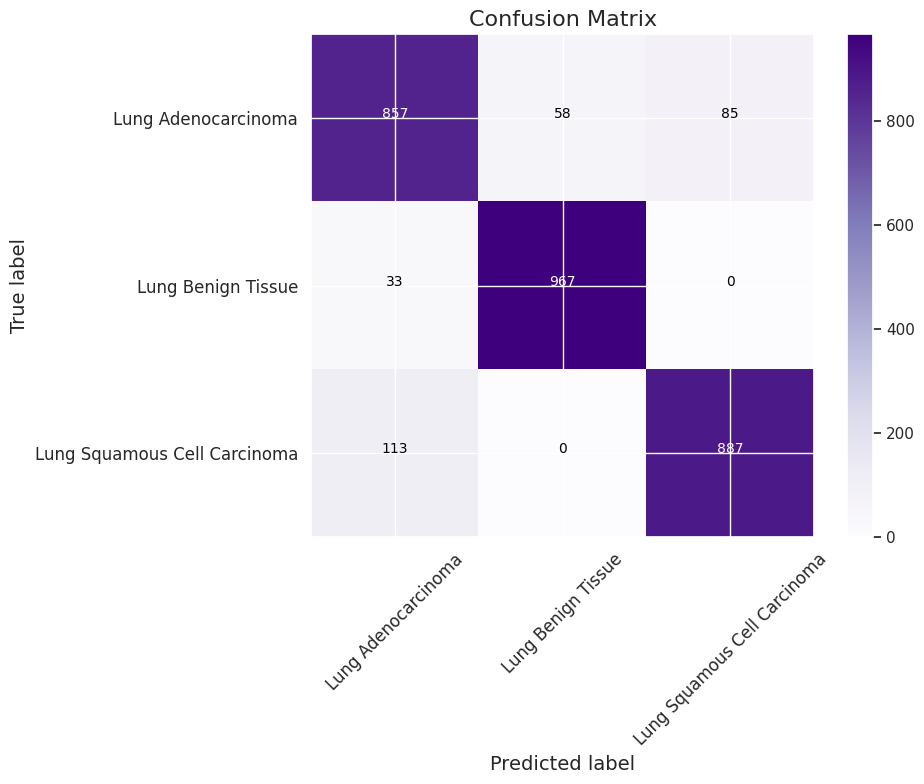

In [29]:
# Example confusion matrix
print("Accuracy_Score: ", accuracy_score(test_labels_encoded, y_pred_svm))
cm_svm = confusion_matrix(test_labels_encoded, y_pred_svm)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_svm, classes)
plt.show()

# **Classification Report SVM**

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report_svm = classification_report(test_labels_encoded, y_pred_svm)
print("Classification Report:")
print(report_svm)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1000
           1       0.94      0.97      0.96      1000
           2       0.91      0.89      0.90      1000

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



# **RandomForestClassifier**

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Đặt phương pháp khởi tạo
with joblib.parallel_backend('threading', n_jobs=-1):
    # Step 3: Define a pipeline for preprocessing and training the model
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling (not necessarily required for RandomForestClassifier)
        ('classifier', RandomForestClassifier())  # Random Forest Classifier
    ])

    # Define hyperparameters for Random Forest
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        # Add more hyperparameters as needed
    }

    # Step 5: Perform grid search cross-validation with k-fold cross-validation
    grid_search_rf = GridSearchCV(rf_pipeline, param_grid, n_jobs=-1)
    grid_search_rf.fit(X_features, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_rf = grid_search_rf.best_estimator_
mean_cv_accuracy_rf = grid_search_rf.best_score_
print("Best Model Parameters (Random Forest):", grid_search_rf.best_params_)
print("Mean Cross-Validation Accuracy (Random Forest):", mean_cv_accuracy_rf)

Best Model Parameters (Random Forest): {'classifier__max_depth': 30, 'classifier__n_estimators': 300}
Mean Cross-Validation Accuracy (Random Forest): 0.9375833333333332


In [32]:
y_pred_rf = best_model_rf.predict(X_test_features)

# **Confusion Matrix RandomForestClassifier**

Accuracy_Score:  0.9426666666666667


<Figure size 800x600 with 0 Axes>

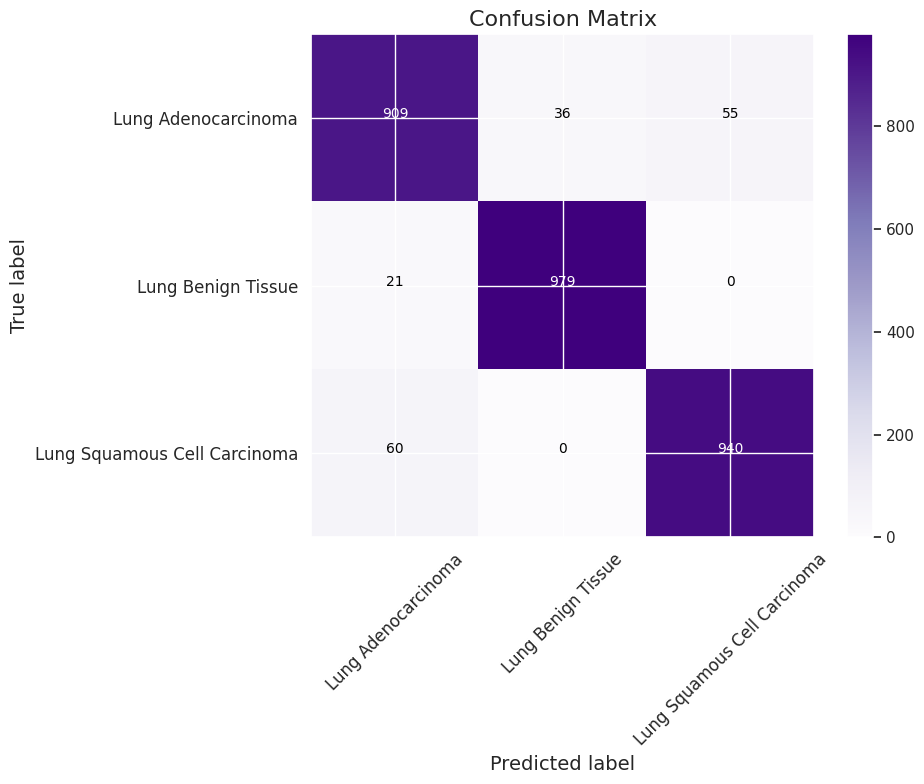

In [33]:
# Example confusion matrix
print("Accuracy_Score: ", accuracy_score(test_labels_encoded, y_pred_rf))
cm_rf = confusion_matrix(test_labels_encoded, y_pred_rf)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_rf, classes)
plt.show()

# **Classification Report RandomForestClassifier**

In [34]:
# Compute the classification report
report_rf = classification_report(test_labels_encoded, y_pred_rf)
print("Classification Report:")
print(report_rf)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1000
           1       0.96      0.98      0.97      1000
           2       0.94      0.94      0.94      1000

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



# **XGBoost**

In [36]:
import xgboost as xgb

# Đặt phương pháp khởi tạo
with joblib.parallel_backend('threading', n_jobs=-1):
    # Step 3: Define a pipeline for preprocessing and training the model
    xgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling (optional)
        ('classifier', xgb.XGBClassifier())  # XGBoost Classifier
    ])

    # Step 4: Define hyperparameters to search over
    param_grid_xgb = {
        'classifier__n_estimators': [3000, 1000, 500],
        'classifier__max_depth': [10, 15, 7],
        'classifier__learning_rate': [0.5, 0.3, 0.2]
    }

    # Step 5: Perform grid search cross-validation with k-fold cross-validation
    grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, n_jobs=-1)
    grid_search_xgb.fit(X_features, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_xgb = grid_search_xgb.best_estimator_
mean_cv_accuracy_xgb = grid_search_xgb.best_score_
print("Best Model Parameters (XGBoost):", grid_search_xgb.best_params_)
print("Mean Cross-Validation Accuracy (XGBoost):", mean_cv_accuracy_xgb)

Best Model Parameters (XGBoost): {'classifier__learning_rate': 0.2, 'classifier__max_depth': 15, 'classifier__n_estimators': 500}
Mean Cross-Validation Accuracy (XGBoost): 0.9368333333333332


In [37]:
y_pred_xgb = best_model_xgb.predict(X_test_features)

# **Confusion Matrix XGB**

Accuracy_Score:  0.9466666666666667


<Figure size 800x600 with 0 Axes>

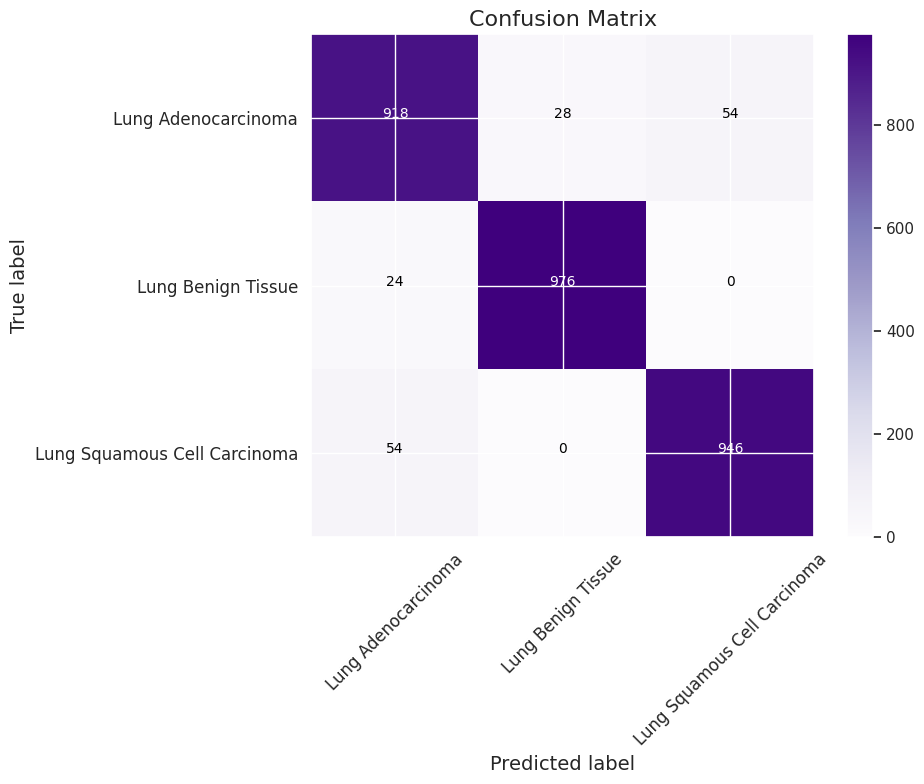

In [38]:
# Example confusion matrix
print("Accuracy_Score: ", accuracy_score(test_labels_encoded, y_pred_xgb))
cm_xgb = confusion_matrix(test_labels_encoded, y_pred_xgb)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_xgb, classes)
plt.show()

# **Classification Report XGB**

In [39]:
# Compute the classification report
report_xgb = classification_report(test_labels_encoded, y_pred_xgb)
print("Classification Report:")
print(report_xgb)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.97      0.98      0.97      1000
           2       0.95      0.95      0.95      1000

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [40]:
def predict_image(path_imgs, labels, model):
    X = load_and_compute_glcm_features(path_imgs)
    y = labels
    
    y_pred = model.predict(X)
    print(X)
    
    for i, path_img in enumerate(path_imgs):
        img = cv2.imread(path_img)
        img = cv2.resize(img, (224, 224))
        
        plt.figure(figsize=(12,12))
        plt.imshow(img)
        plt.title(f"Label: {y}")
        plt.xlabel(f"Predicted label: {classes[y_pred[0]]}")
        plt.show()

[[9.29404505 0.03494543 0.42851382 0.99753238 7.34077098]]


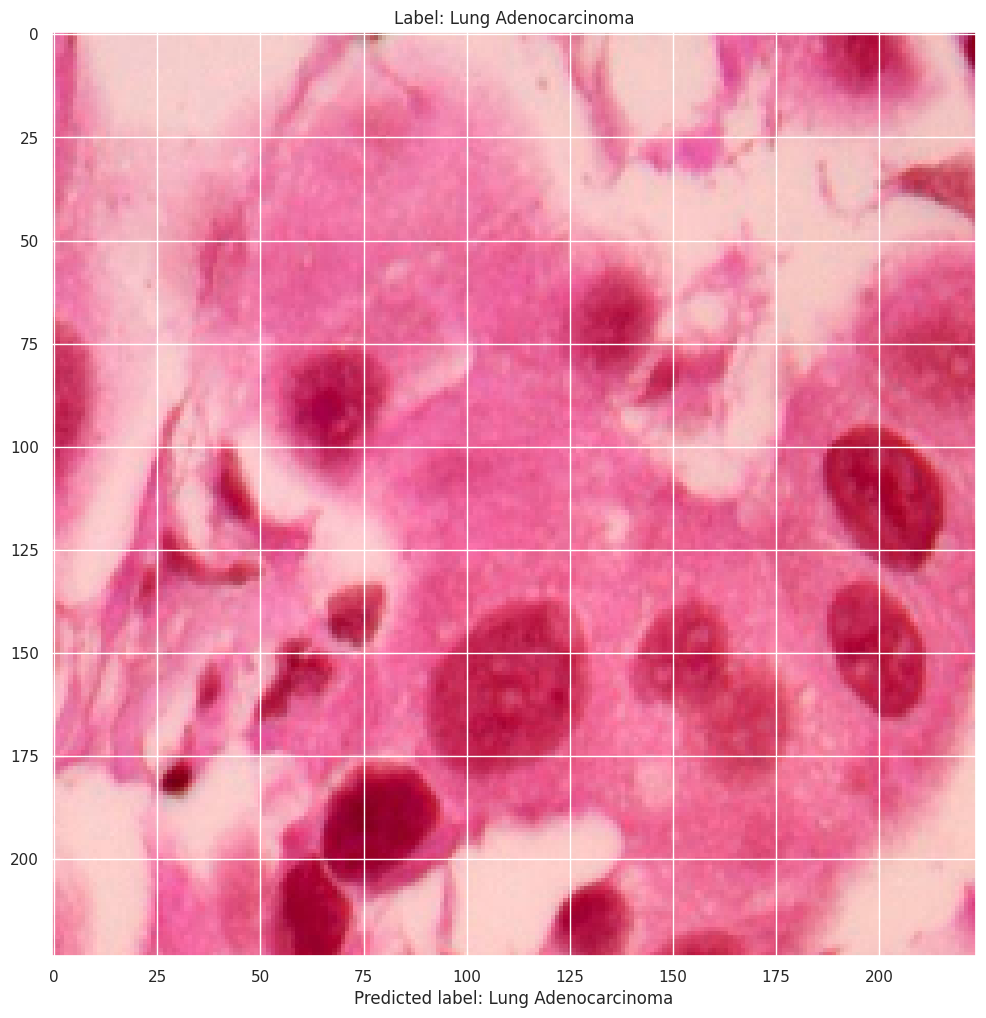

In [41]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4376.jpeg"], "Lung Adenocarcinoma", best_model_rf)

In [42]:
from joblib import dump, load

# Lưu mô hình
dump(best_model_svm, 'svm_model.joblib')

# Lưu mô hình
dump(best_model_rf, 'randomforest_model.joblib')

# Lưu mô hình
dump(best_model_xgb, 'xgboost_model.joblib')

['xgboost_model.joblib']

In [43]:
# Tải mô hình
svm_loaded = load('/kaggle/working/svm_model.joblib')

# Tải mô hình
rfc_loaded = load('/kaggle/working/randomforest_model.joblib')

# Tải mô hình
xgb_loaded = load('/kaggle/working/xgboost_model.joblib')

[[9.2704989  0.07149756 0.51863976 0.99589254 6.56810298]]


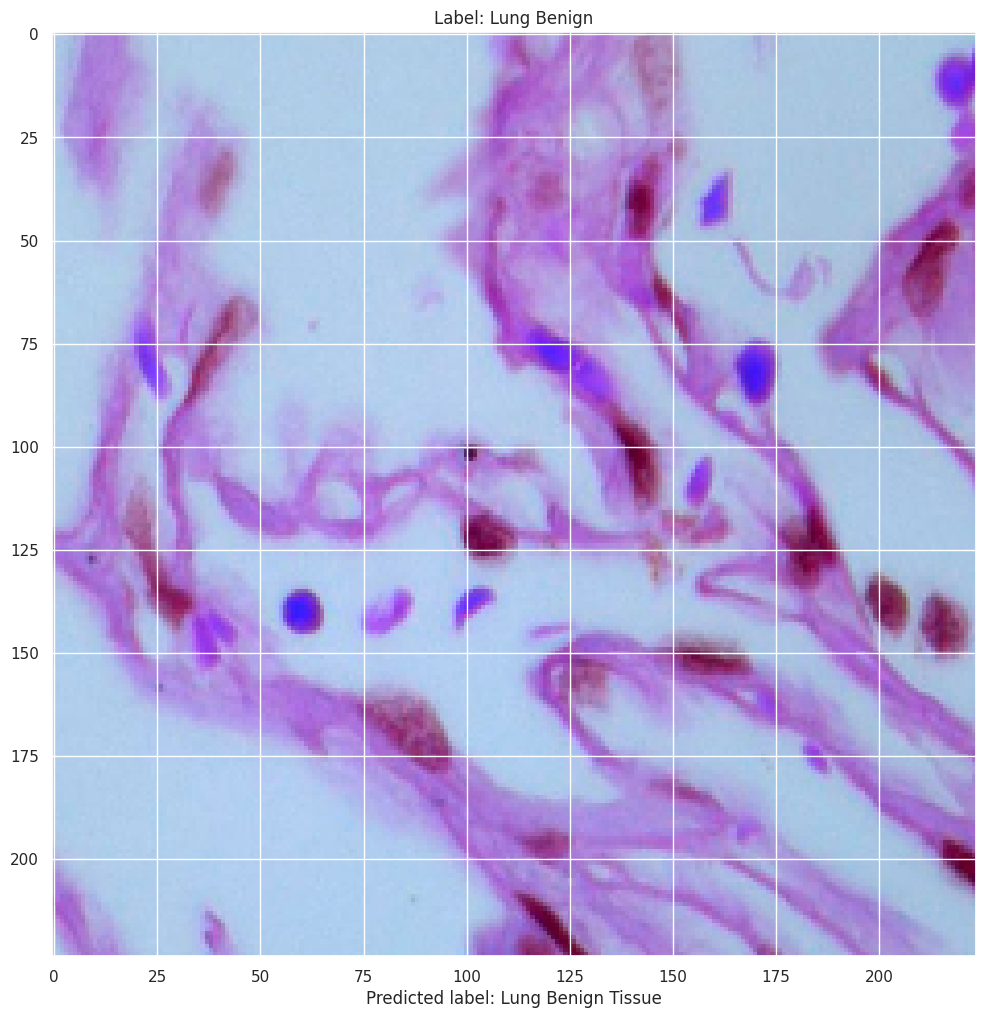

In [44]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4376.jpeg"], "Lung Benign", rfc_loaded)

[[9.2704989  0.07149756 0.51863976 0.99589254 6.56810298]]


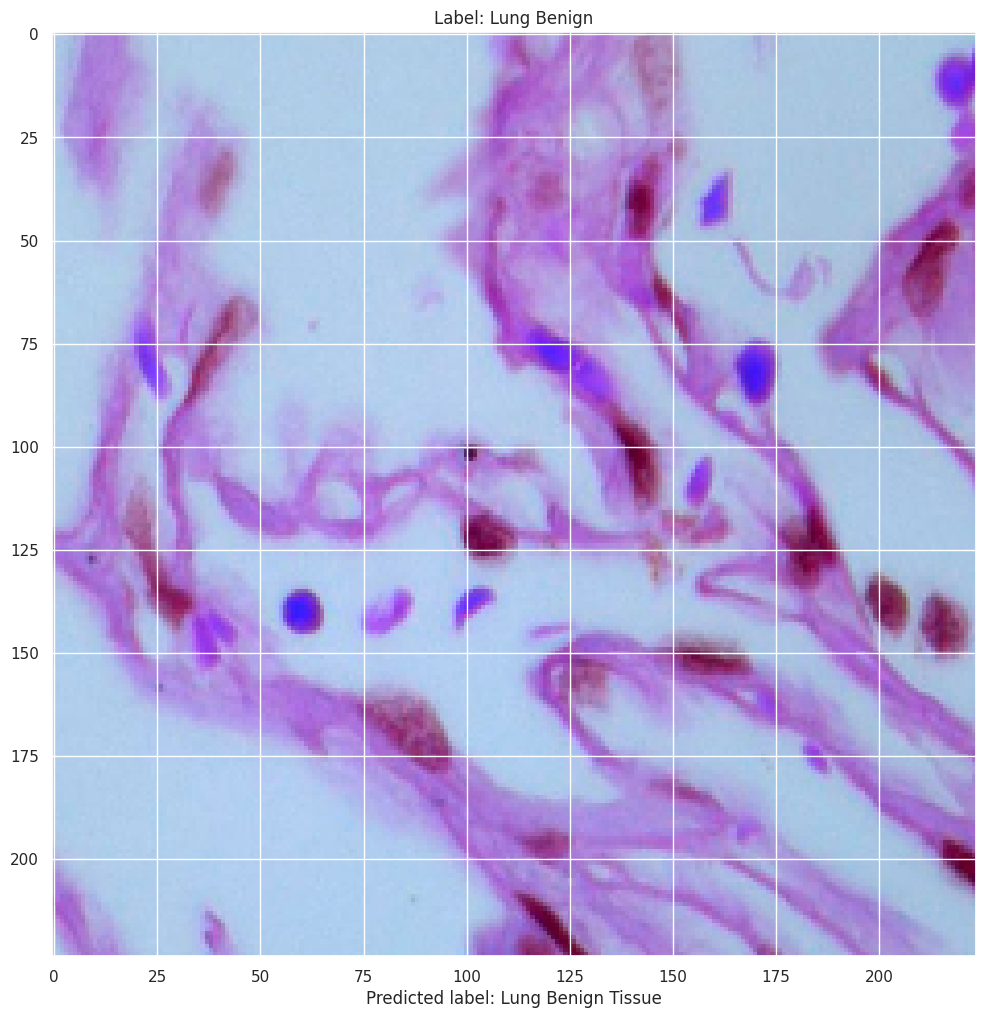

In [45]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4376.jpeg"], "Lung Benign", svm_loaded)

[[9.2704989  0.07149756 0.51863976 0.99589254 6.56810298]]


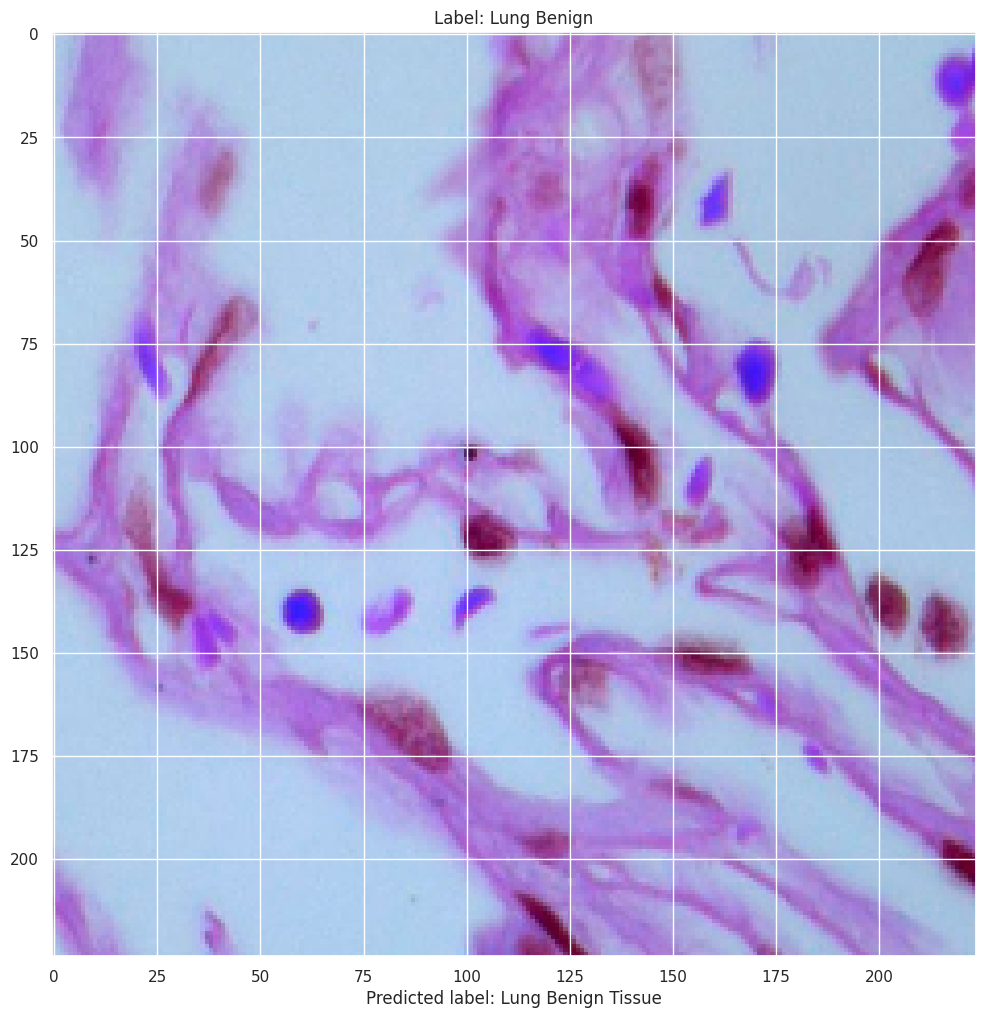

In [46]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4376.jpeg"], "Lung Benign", xgb_loaded)

# Phân tích lỗi sai

## classes = ['Lung Adenocarcinoma', 'Lung Benign Tissue', 'Lung Squamous Cell Carcinoma']

In [47]:
def read_data_test(data_dir):
    filepaths = []  # Sửa tên biến
    filelist = os.listdir(data_dir)

    for file in filelist:
        fpath = os.path.join(data_dir, file)  # Sửa biến từ f_path thành data_dir
        filepaths.append(fpath)

    data = pd.DataFrame(filepaths, columns=["filepaths"])  # Sửa định nghĩa cột thành danh sách
    
    return data


In [48]:
def predict(data, label, model, classes):
    # Tải và tính toán các đặc trưng GLCM
    X = load_and_compute_glcm_features(data['filepaths'])
    
    # Dự đoán nhãn
    y_pred = model.predict(X)
    
    # Lặp qua từng ảnh và so sánh với nhãn thực tế
    for i, path_img in enumerate(data['filepaths']):
        if classes[y_pred[i]] != label:
            print(path_img)


# SVM model 

## Adenocarcinoma

In [49]:
data_adenocarcinoma = read_data_test("/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma")

In [50]:
predict(data_adenocarcinoma, "Lung Adenocarcinoma", svm_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4839.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4614.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4438.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4517.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4779.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4597.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4565.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4943.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4881.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4766.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4917.jpeg
/kaggle/input/lung-ca

[[11.27302667  0.03158622  0.37693706  0.99520892  7.34372577]]


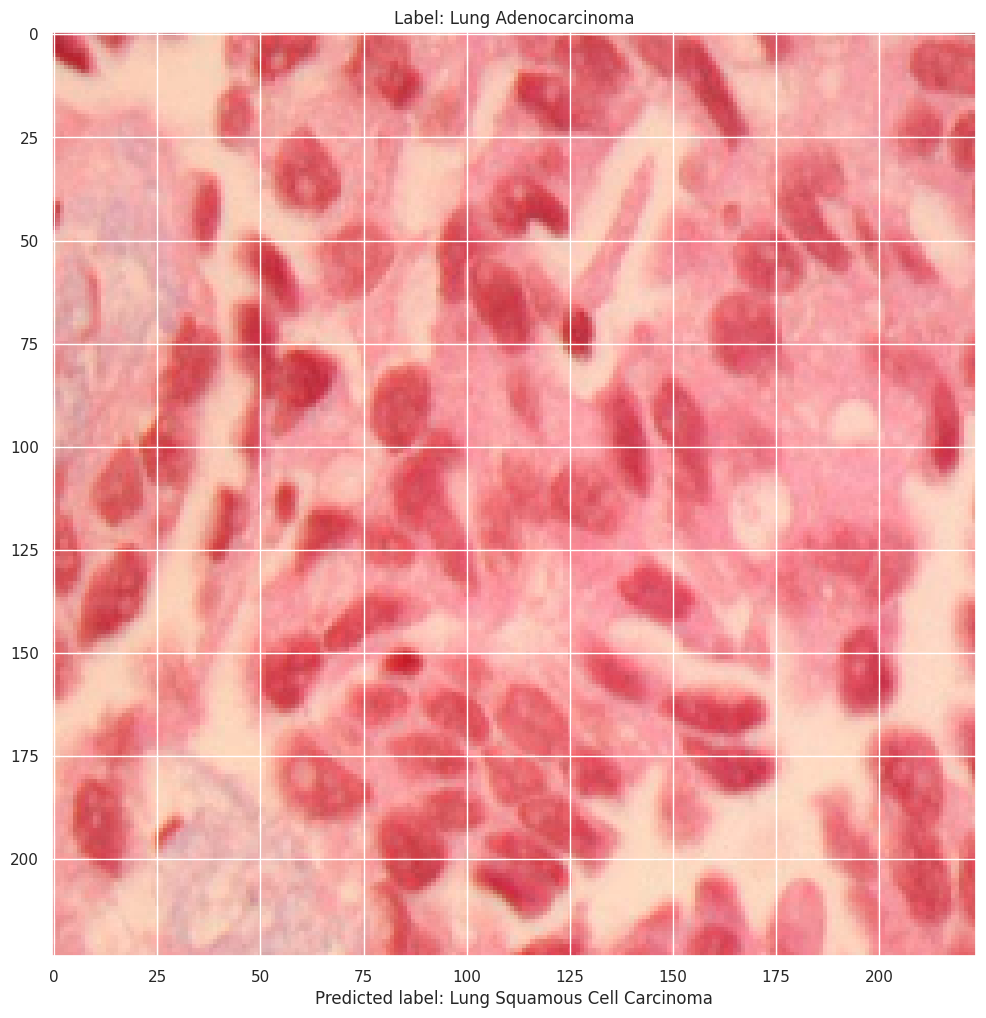

In [65]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4597.jpeg"], "Lung Adenocarcinoma", svm_loaded)

## Benign

In [51]:
data_benign = read_data_test("/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign")

In [52]:
predict(data_benign, "Lung Benign Tissue", svm_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4714.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4471.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4972.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4888.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4917.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4737.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4574.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4420.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4993.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4679.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4656.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4655.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/

[[9.58375095 0.06169102 0.46927945 0.99685273 6.88426658]]


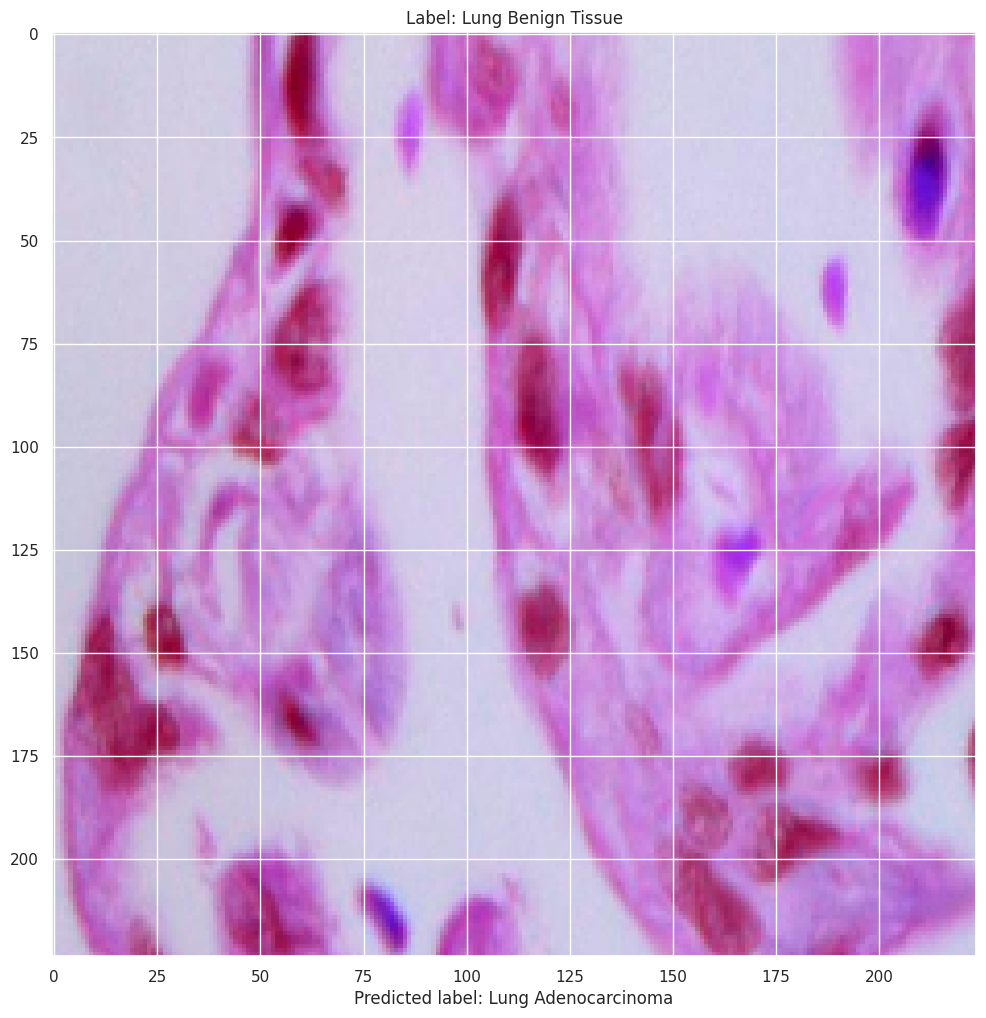

In [53]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4679.jpeg"], "Lung Benign Tissue", svm_loaded)

## Squamous_carcinoma

In [54]:
data_squamous_carcinoma = read_data_test("/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma")

In [55]:
predict(data_squamous_carcinoma, "Lung Squamous Cell Carcinoma", svm_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4938.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4523.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4943.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4418.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4635.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4416.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4861.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4848.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4889.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4581.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carc

[[10.28878748  0.03852229  0.41159929  0.99544153  7.17322292]]


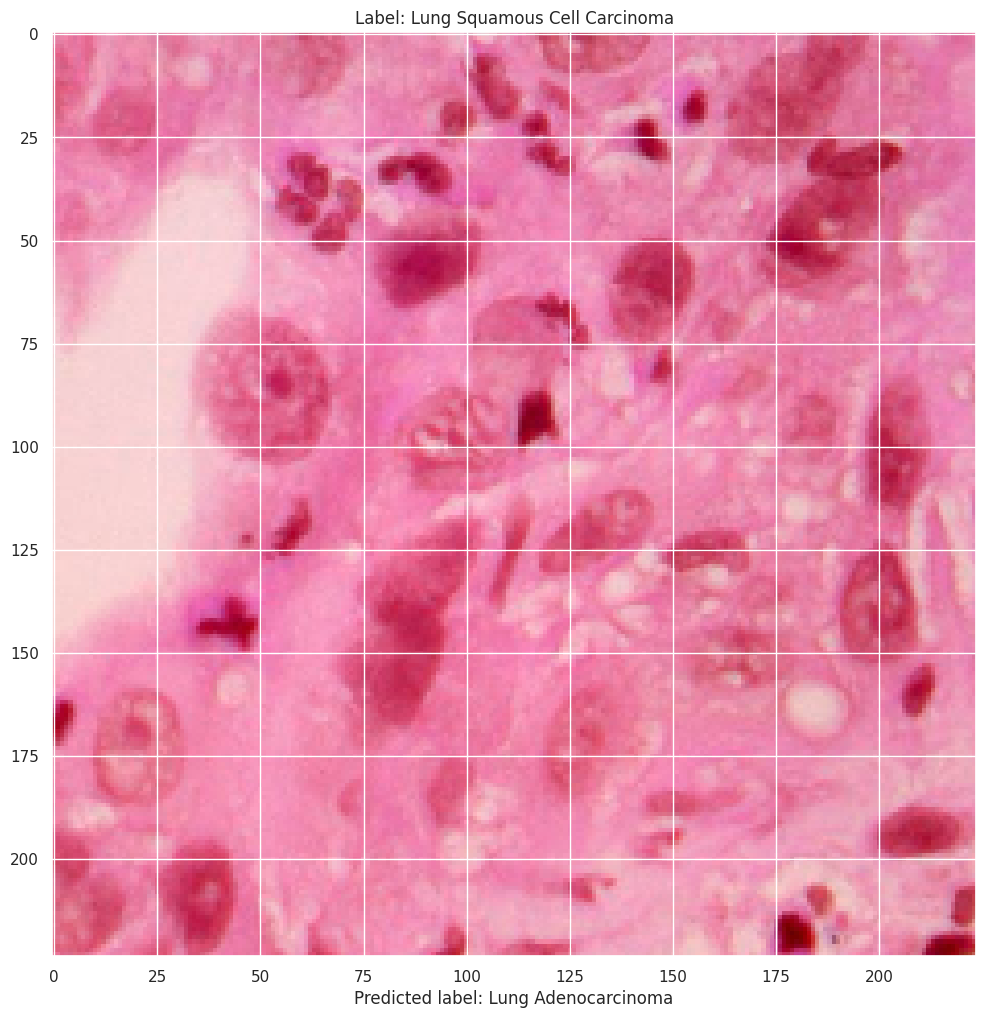

In [56]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4427.jpeg"], "Lung Squamous Cell Carcinoma", svm_loaded)

## RandomforestClassifier

## Adenocarcinoma

In [57]:
predict(data_adenocarcinoma, "Lung Adenocarcinoma", rfc_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4870.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4454.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4922.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4772.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4832.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4989.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4939.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4613.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4738.jpeg


[[11.0086036   0.07965333  0.50827093  0.99636607  6.62480378]]


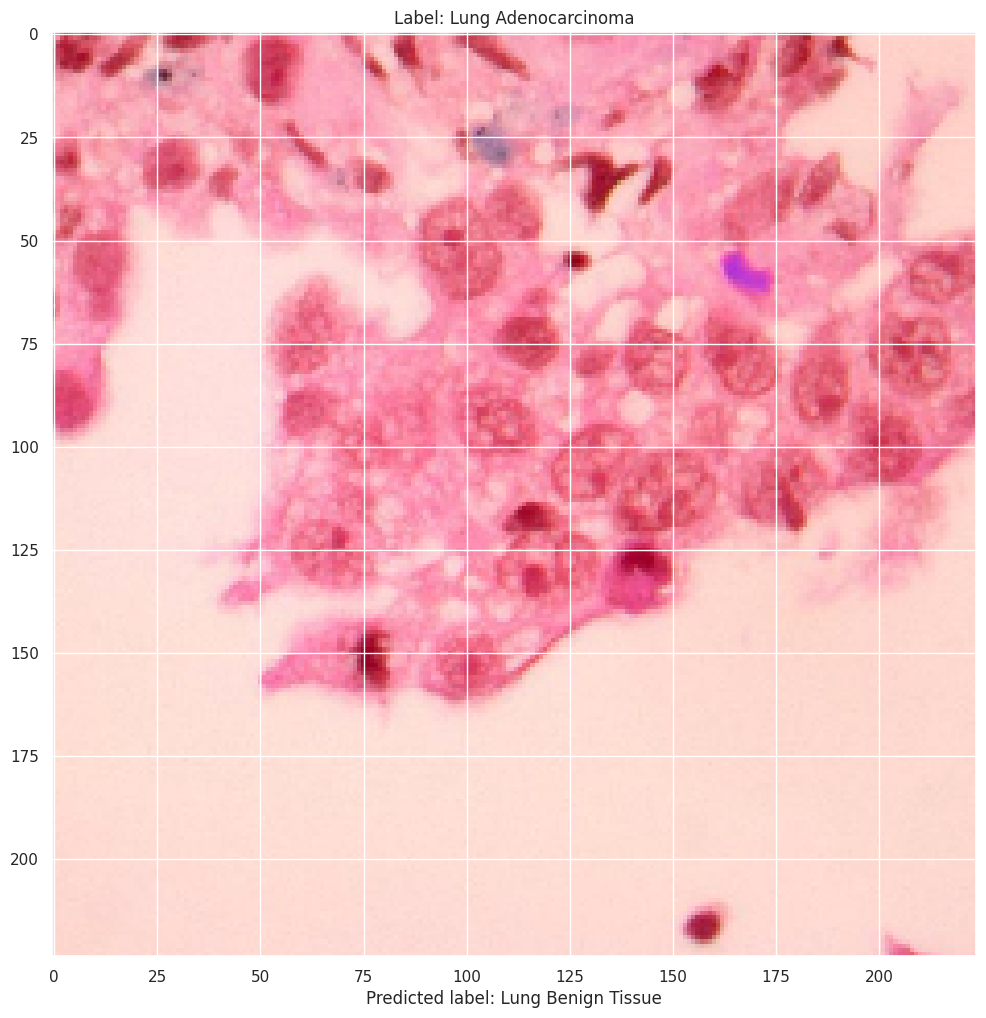

In [58]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4738.jpeg"], "Lung Adenocarcinoma", rfc_loaded)

## Benign

In [59]:
predict(data_benign, "Lung Benign Tissue", rfc_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4718.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4574.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4579.jpeg


[[13.64561264  0.05159562  0.44368403  0.9962921   7.19629316]]


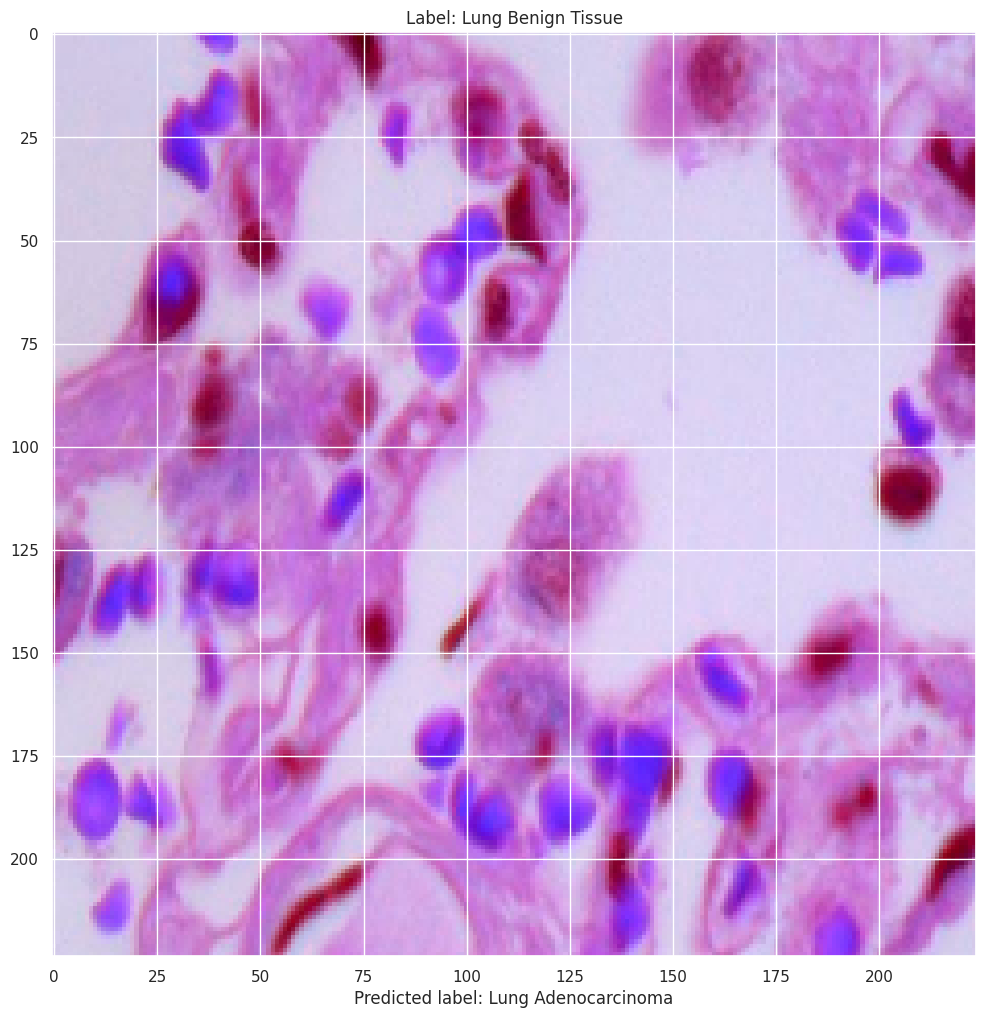

In [60]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4579.jpeg"], "Lung Benign Tissue", rfc_loaded)

## Squamous Cell Carcinoma

In [61]:
predict(data_squamous_carcinoma, "Lung Squamous Cell Carcinoma", rfc_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4543.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4667.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4500.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4460.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4381.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4742.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4843.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4487.jpeg


[[8.54711267 0.04009449 0.42607087 0.99634031 7.10436257]]


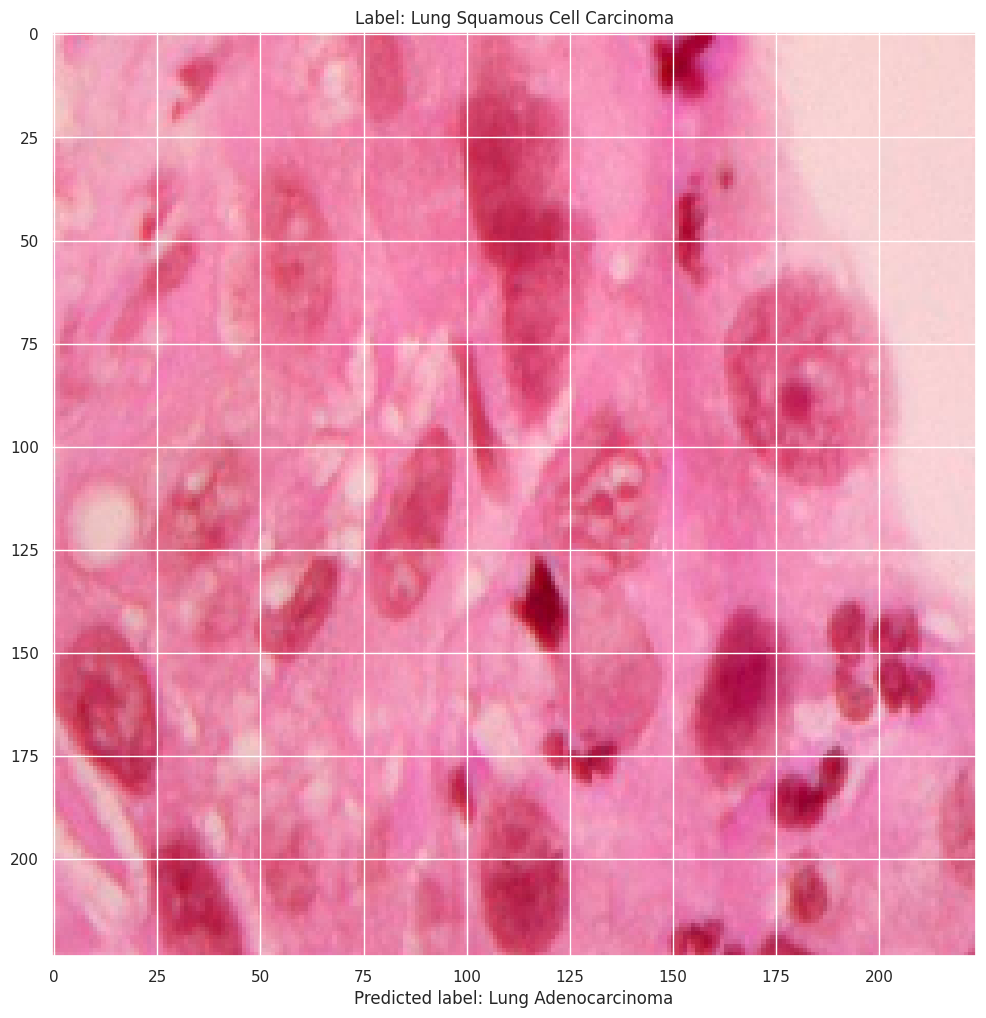

In [62]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4487.jpeg"], "Lung Squamous Cell Carcinoma", rfc_loaded)

## XGBoost

## Adenocarcinoma

In [63]:
predict(data_adenocarcinoma, "Lung Adenocarcinoma", xgb_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4870.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4454.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4922.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4832.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4391.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4989.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4939.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4613.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4738.jpeg


[[11.0086036   0.07965333  0.50827093  0.99636607  6.62480378]]


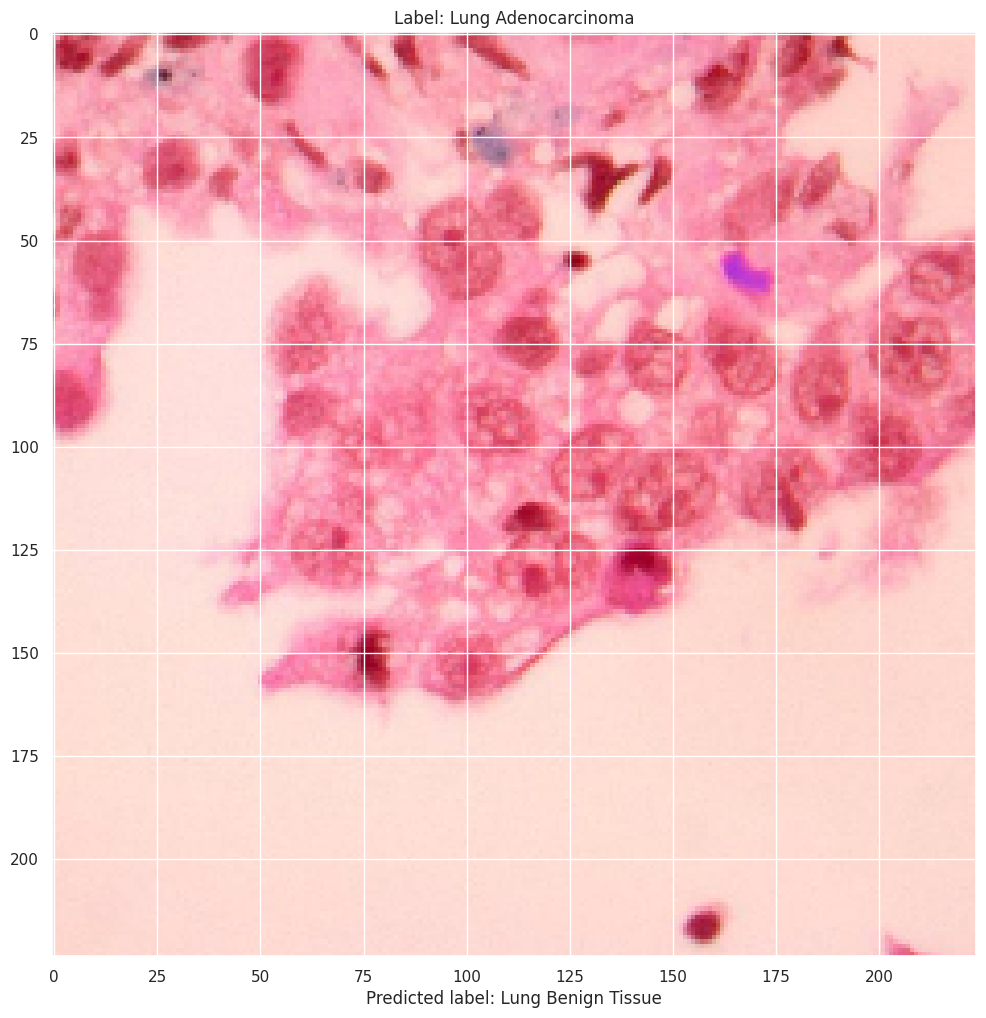

In [66]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4738.jpeg"], "Lung Adenocarcinoma", xgb_loaded)

## Benign

In [67]:
predict(data_benign, "Lung Benign Tissue", xgb_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4718.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4574.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4561.jpeg


[[13.66730667  0.06625079  0.45530889  0.99533121  6.93098849]]


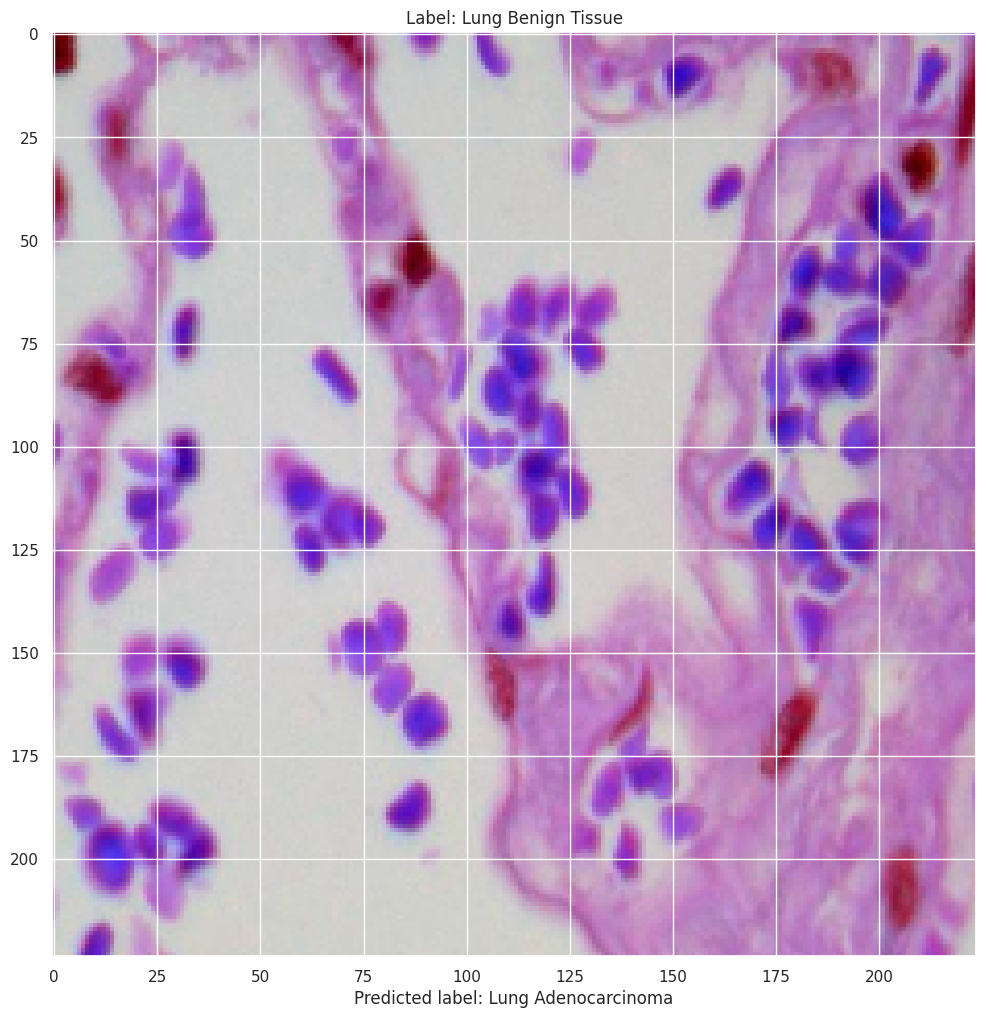

In [68]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4561.jpeg"], "Lung Benign Tissue", xgb_loaded)

## Squamous Cell Carcinoma

In [69]:
predict(data_squamous_carcinoma, "Lung Squamous Cell Carcinoma", xgb_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4543.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4500.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4460.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4381.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4742.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4487.jpeg


[[8.54711267 0.04009449 0.42607087 0.99634031 7.10436257]]


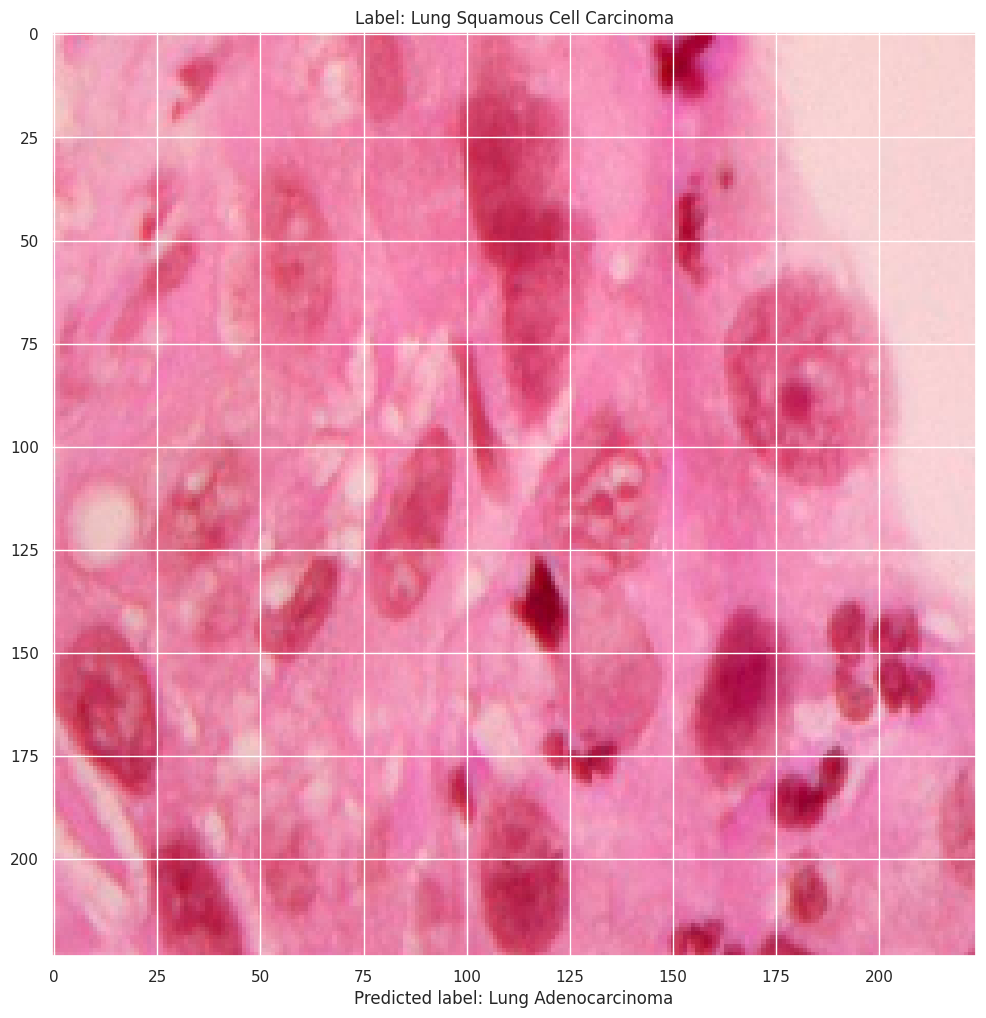

In [70]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4487.jpeg"], "Lung Squamous Cell Carcinoma", xgb_loaded)

In [71]:
train = df_train
train['labels'] = y_encoded
train

Contrast    Energy  Homogeneity  Correlation   Entropy  labels
0      15.247092  0.049940     0.448455     0.995636  7.191454       1
1       7.811994  0.049183     0.420259     0.991010  6.645922       2
2      10.780773  0.066392     0.516103     0.996156  6.737162       1
3      20.330544  0.061243     0.451985     0.993823  7.048412       1
4      19.789626  0.044366     0.385595     0.990726  7.154070       0
...          ...       ...          ...          ...       ...     ...
11995   9.899072  0.100422     0.584643     0.995865  6.048204       1
11996   7.465351  0.038784     0.434301     0.996630  7.094896       0
11997  14.956478  0.027917     0.345535     0.994349  7.614012       0
11998  16.930417  0.030430     0.324775     0.991723  7.511381       2
11999  17.675807  0.061443     0.464150     0.994368  6.976058       1

[12000 rows x 6 columns]

In [72]:
# Tính giá trị trung bình của các feature dựa vào label
mean_features_by_label = train.groupby('labels').mean()

print(mean_features_by_label)

         Contrast    Energy  Homogeneity  Correlation   Entropy
labels                                                         
0       16.710074  0.038100     0.386385     0.994817  7.442596
1       14.413606  0.068996     0.494097     0.995265  6.782775
2       16.550858  0.034061     0.338671     0.990997  7.359972


In [73]:
# Tính giá trị nhỏ nhất (min) và lớn nhất (max) của các feature dựa vào label
min_max_features_by_label = train.groupby('labels').agg(['min', 'max'])

print(min_max_features_by_label)

        Contrast               Energy           Homogeneity            \
             min        max       min       max         min       max   
labels                                                                  
0       3.958741  49.568238  0.018237  0.109676    0.241039  0.608213   
1       2.236202  33.123538  0.032220  0.162712    0.360237  0.711069   
2       2.898670  58.998784  0.018417  0.069802    0.187989  0.555759   

       Correlation             Entropy            
               min       max       min       max  
labels                                            
0         0.983601  0.998760  5.888516  8.427191  
1         0.989911  0.998242  4.585474  7.692064  
2         0.973075  0.997422  6.035305  8.374600  
